In [2]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import STL
from arch.unitroot import PhillipsPerron
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt

In [3]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2021-01-1')]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
geo_fire_data['day'] = 1
geo_fire_data['year'] = pd.Series(pd.to_numeric(geo_fire_data['year'], errors='coerce'), dtype='int64')
geo_fire_data['month'] = pd.Series(pd.to_numeric(geo_fire_data['month'], errors='coerce'), dtype='int64')
geo_fire_data['ModifiedDateTime'] = pd.to_datetime(geo_fire_data[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on time
fires_count = geo_fire_data.sort_values(by=['ModifiedDateTime'])
fires_count = fires_count.set_index(pd.to_datetime(fires_count.pop('ModifiedDateTime'))).resample('M')['fireID'].count()
fires_count = fires_count.to_frame()



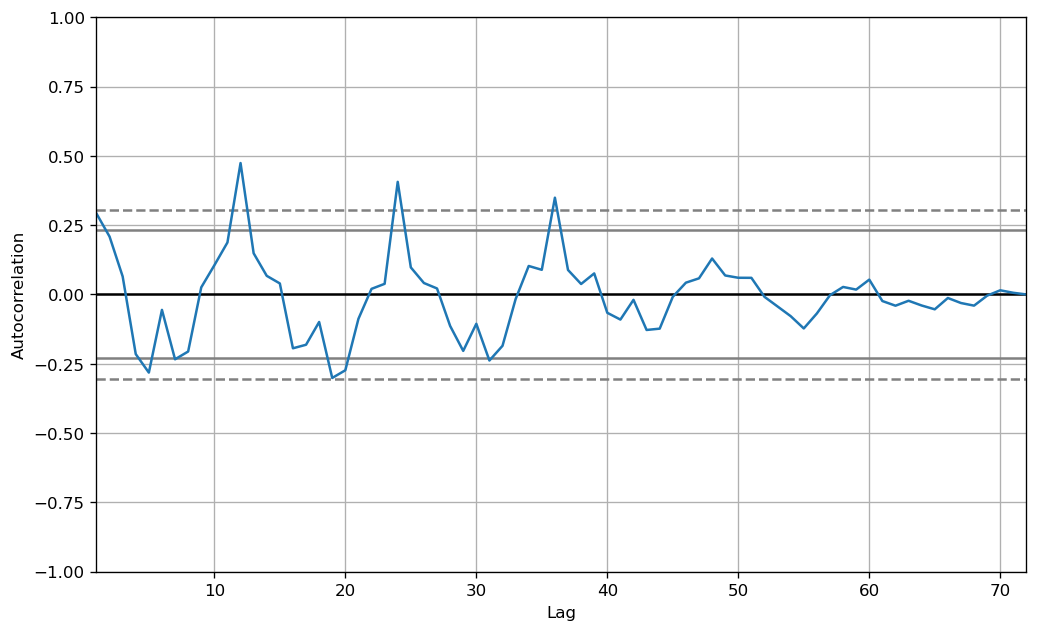

In [6]:
# Test for seasonality
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(fires_count['fireID'].tolist())
plt.show()
# There is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

In [7]:
#Test for Stationarity for forecasting

#ADF Augmented Dickey Fuller Test
#H0: the time series has a unit root (i.e. associated with non-stionary data)
#H1: the times series is higly likely to lack a unit root and thus can be considered as associated with stationary data.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
print('Results of ADF Test:')
X = fires_count['fireID']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print('\n')

#Kpss Test
#H0: the time series tested is considered to be stationary
#H1: the TS should be considered as non-stationary (there is a unit root).
print ('Results of KPSS Test:')
kpsstest = kpss(X, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

#Phillips — Perron Test
#H0: The process contains a unit root.
#H1: The process is stationary.
php_ct = PhillipsPerron(X)
php_ct.summary()


Results of ADF Test:
ADF Statistic: -1.470801
p-value: 0.547903
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593


Results of KPSS Test:
Test Statistic           0.194185
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic,-5.768
P-value,0.000
Lags,12


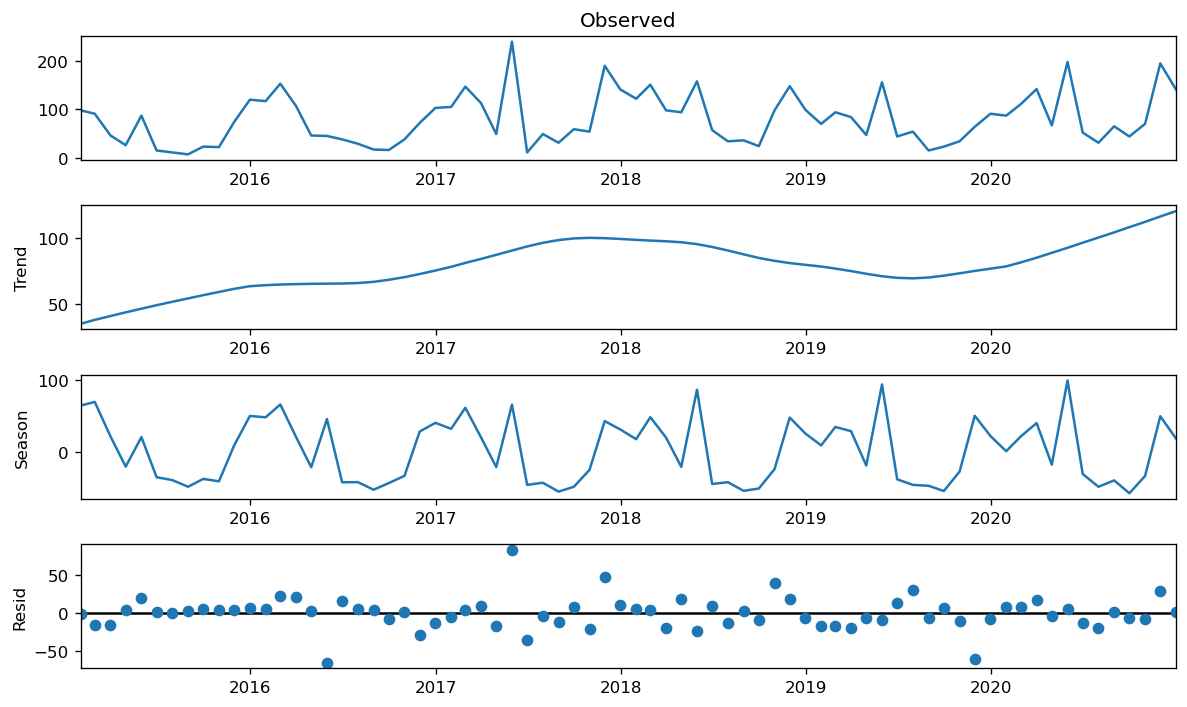

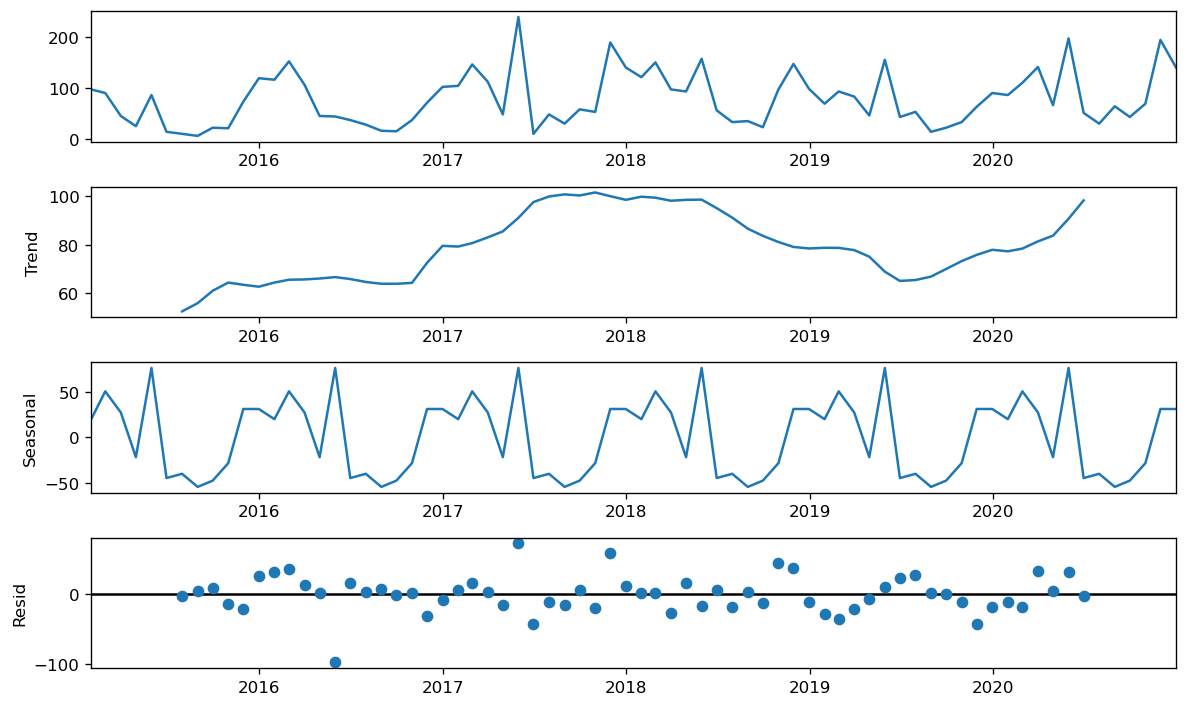

In [8]:
#Decompose using STL Seasonal-Trend Decomposition using LOESS
stl = STL(fires_count, seasonal=7)
res = stl.fit()
res.plot()

#Moving Averages
result_year = seasonal_decompose(fires_count, model='additive')
result_year.plot()
plt.show()


In [9]:
df_trend = res.trend.to_frame().reset_index().dropna()
df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

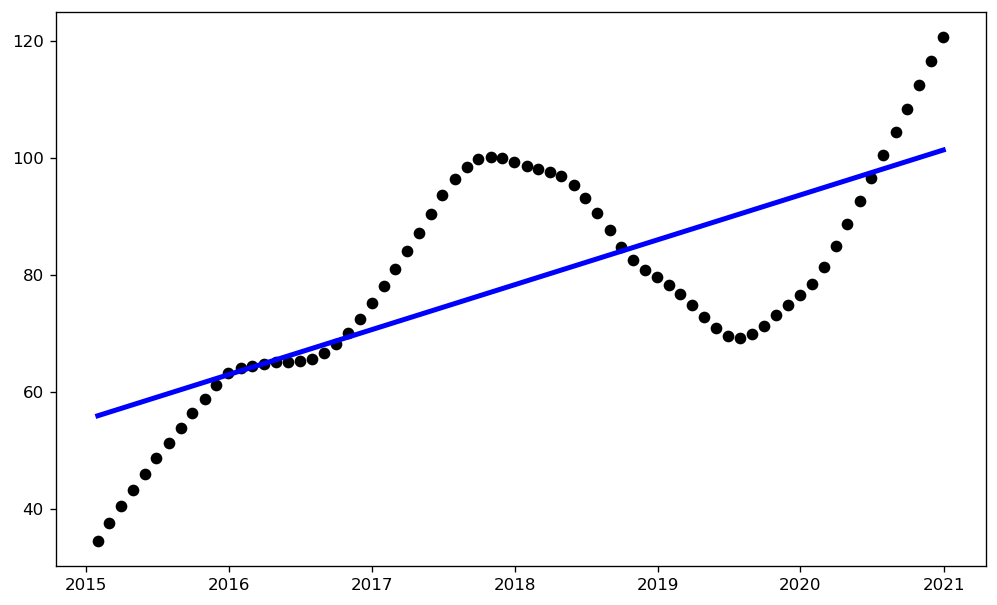

[0.02102612] [-15411.48523488]


In [10]:
X = np.array(df_trend['ModifiedDateTime_num'])
X = X.reshape(-1, 1)
y = np.array(df_trend['trend'])
y = y.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

y_pred_trend = reg.predict(X)

plt.scatter(df_trend['ModifiedDateTime'], df_trend['trend'], color="black")
plt.plot(df_trend['ModifiedDateTime'], y_pred_trend, color="blue", linewidth=3)
plt.show()

slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
print(slope, intercept)

In [11]:
#Sort the values based on time
fires_count = geo_fire_data.sort_values(by=['ModifiedDateTime'])
fires_count = fires_count.set_index(pd.to_datetime(fires_count.pop('ModifiedDateTime'))).resample('M')['frp'].mean()
fires_count = fires_count.to_frame()
fires_count = fires_count.fillna(0)

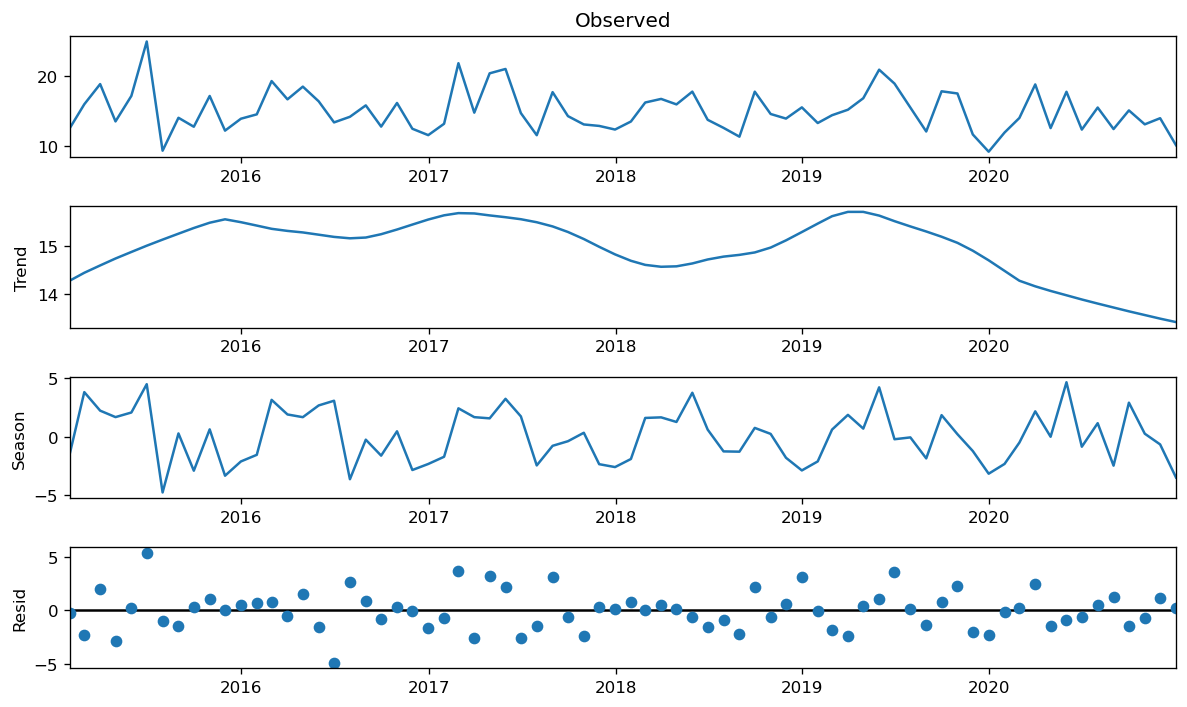

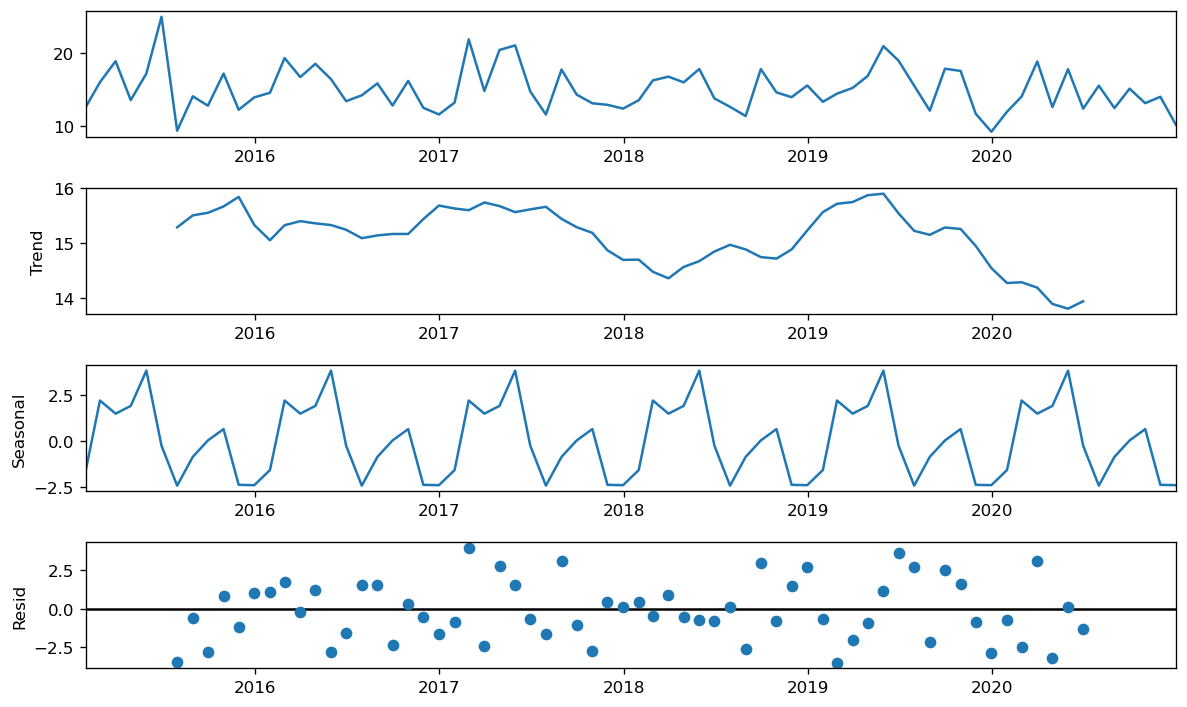

In [12]:
#Decompose using STL Seasonal-Trend Decomposition using LOESS
stl = STL(fires_count, seasonal=13)
res = stl.fit()
res.plot()

#Moving Averages
result_year = seasonal_decompose(fires_count, model='additive')
result_year.plot()
plt.show()